# Individual notebook for week 11: sub-question analysis on additional datasets

**Ziyang Lin (zlin4387)**

Note: This notebook will also contain contents from my previous notebooks.

Load the raw data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

dataset_path = Path('../../../datasets')
raw_data_p1 = pd.read_csv(dataset_path / 'Participant-01-second-detail.csv')
raw_data_p2 = pd.read_csv(dataset_path / 'Participant-02-detail.csv')
raw_data_p5 = pd.read_csv(dataset_path / 'Participant-05-detail.csv')

We perform data cleaning step, converting the `Date` column to a timestamp and extracting the year, month, day, and hour from it.

In [2]:
def clean_data(dataset):
    dataset = dataset.copy()
    dataset[['Year', 'Month', 'Day']] = dataset['Date'].str.split('-', 2, expand=True).astype('int')
    dataset['Timestamp'] = pd.to_datetime(dataset[['Year', 'Month', 'Day', 'Hour']])
    dataset['Weekday'] = dataset['Timestamp'].dt.weekday

    cleaned_data = dataset[['Timestamp', 'Source', 'Weekday', 'Year', 'Month', 'Day', 'Hour', 'Count']]
    return cleaned_data

cleaned_p1 = clean_data(raw_data_p1)
cleaned_p2 = clean_data(raw_data_p2)
cleaned_p5 = clean_data(raw_data_p5)
cleaned_p1.head()

,Timestamp,Source,Weekday,Year,Month,Day,Hour,Count
0,2022-01-01 07:00:00,P1 Apple Watch,5,2022,1,1,7,32
1,2022-01-01 07:00:00,P1 Apple Watch,5,2022,1,1,7,49
2,2022-01-01 07:00:00,P1 Apple Watch,5,2022,1,1,7,14
3,2022-01-01 07:00:00,P1 Apple Watch,5,2022,1,1,7,20
4,2022-01-01 07:00:00,P1 Apple Watch,5,2022,1,1,7,16


In [3]:
cleaned_p2.head()

,Timestamp,Source,Weekday,Year,Month,Day,Hour,Count
0,2022-01-01 05:00:00,P2 Phone,5,2022,1,1,5,31
1,2021-12-31 21:00:00,P2’s Apple Watch,4,2021,12,31,21,20
2,2021-12-31 21:00:00,P2’s Apple Watch,4,2021,12,31,21,16
3,2022-01-01 05:00:00,P2’s Apple Watch,5,2022,1,1,5,29
4,2022-01-01 05:00:00,P2’s Apple Watch,5,2022,1,1,5,13


For Participant 1 and 2, because the dataset contains data points from both their mobile phone and smartwatch, aggregating would resulting in duplicate data. We keep only data from the smartwatch as it is usually more accurate. 

In [4]:
cleaned_p1 = cleaned_p1[cleaned_p1['Source'].str.contains('Watch')]
cleaned_p2 = cleaned_p2[cleaned_p2['Source'].str.contains('Watch')]
cleaned_p1['Source'].unique(), cleaned_p2['Source'].unique(), cleaned_p5['Source'].unique()

(array(['P1 Apple\xa0Watch'], dtype=object),
 array(['P2’s Apple\xa0Watch'], dtype=object),
 array(['person5'], dtype=object))

## Sub-question

We're interested in how frequent the participant reaches the recommended 7,500-[1] and 10,000-step[2] goal.

Take participant 2 as an exmaple. We first calculate their daily step counts:

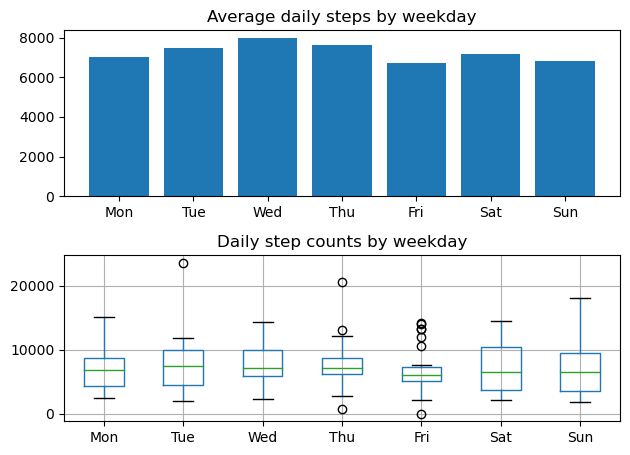

In [5]:
# labels for more readable plots
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

daily_sums = cleaned_p2.groupby(['Year', 'Month', 'Day', 'Weekday'], as_index=False)['Count'].sum()
# daily_sums['WeekdayStr'] = daily_sums['Weekday'].map(lambda x : weekdays[x])
weekday_avgs = daily_sums.groupby('Weekday')['Count'].agg(np.average)

fig, axs = plt.subplots(2, 1)
axs[0].bar(weekdays, weekday_avgs)
axs[0].set_title('Average daily steps by weekday')

daily_sums.boxplot(column='Count', by='Weekday', ax=axs[1])
axs[1].set_title('Daily step counts by weekday')
axs[1].set_xticks(np.arange(7) + 1, labels=weekdays)
axs[1].set_xlabel(None)

fig.suptitle('')
fig.tight_layout()
plt.show()

From the plots we can see that participant 2 is most active on Wednesdays on average, and least active on Fridays with lowest mean and median daily steps.

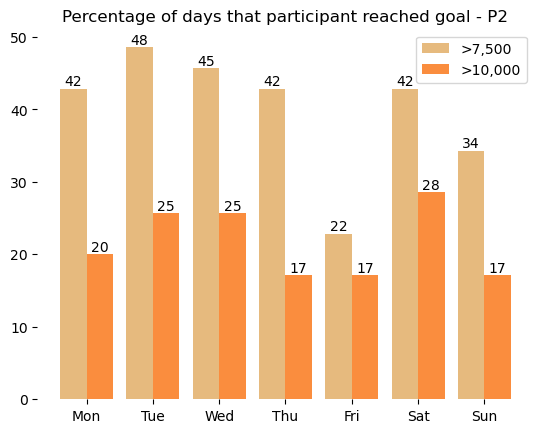

In [6]:
num_weekday_days = daily_sums.groupby('Weekday').size()
p_days_7500 = daily_sums[daily_sums['Count'] > 7500].groupby('Weekday').size() / num_weekday_days * 100
p_days_10000 = daily_sums[daily_sums['Count'] > 10000].groupby('Weekday').size() / num_weekday_days * 100

x = np.arange(7)
width = 0.4

fig, ax = plt.subplots()

bar_7500 = ax.bar(x - width / 2, p_days_7500, width=width, color='#E6BA7E', label='>7,500')
ax.bar_label(bar_7500, fmt='%d')
bar_10000 = ax.bar(x + width / 2, p_days_10000, width=width, color='#FA8D3E', label='>10,000')
ax.bar_label(bar_10000, fmt='%d')

ax.set(frame_on=False)
plt.title('Percentage of days that participant reached goal - P2')
plt.xticks(x, labels=weekdays)
plt.legend()
plt.show()

The plot agrees with the other statistics. We can see that the participant usually walks more on Tuesdays, Wednesdays, and Saturdays. Friday is the overall least active day. 

To see the the trends over a longer time period, we group the data by month and see the percentage of days within each month that the participant reached their goal. 

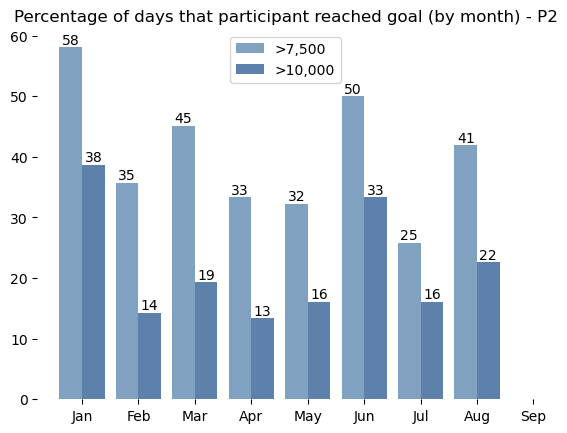

In [7]:
# show only data in 2022
num_month_days = daily_sums[daily_sums['Year'] == 2022].groupby('Month').size()
p_days_7500 = daily_sums[daily_sums['Count'] > 7500].groupby('Month').size() / num_month_days * 100
p_days_10000 = daily_sums[daily_sums['Count'] > 10000].groupby('Month').size() / num_month_days * 100

x = daily_sums[daily_sums['Year'] == 2022]['Month'].unique()
labels = [months[mo - 1] for mo in x]
width = 0.4

fig, ax = plt.subplots()
bar_7500 = ax.bar(x - width / 2, p_days_7500, width=width, color='#81A1C1', label='>7,500')
ax.bar_label(bar_7500, fmt='%d')
bar_10000 = ax.bar(x + width / 2, p_days_10000, width=width, color='#5E81AC', label='>10,000')
ax.bar_label(bar_10000, fmt='%d')
ax.set_xticks(x, labels)

ax.set(frame_on=False)
plt.title('Percentage of days that participant reached goal (by month) - P2')
plt.legend()
plt.show()

We notice that the participant was the most active in January and June. One possible explanation is that university vacations allowed them to travel or exercise more often than on other days.

We can test our hypothesis that the participant has a higher average daily step count in January and June.

In [8]:
from scipy.stats import ttest_ind

steps_jan = daily_sums[daily_sums['Month'] == 1]
steps_jun = daily_sums[daily_sums['Month'] == 6]
steps_other = daily_sums[(daily_sums['Month'] != 1) & (daily_sums['Month'] != 6)]

print('January:', ttest_ind(steps_jan['Count'], steps_other['Count'], equal_var=False, alternative='greater'))
print('June:', ttest_ind(steps_jun['Count'], steps_other['Count'], equal_var=False, alternative='greater'))


January: Ttest_indResult(statistic=2.6652492711837286, pvalue=0.005540895651204344)
June: Ttest_indResult(statistic=1.4209818521982067, pvalue=0.08238712385663774)


In the January sample, we observed a p-value less than 0.05. We reject the null hypothesis and conclude that participant 2 is more active in January than rest of the time.

However, the June sample yielded a p-value greater than 0.05, so we retain the null hypothesis.

### Other datasets

We can then apply the same method to the other datasets.

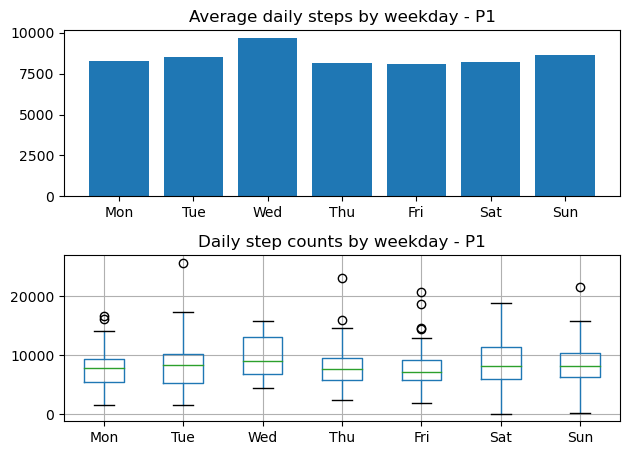

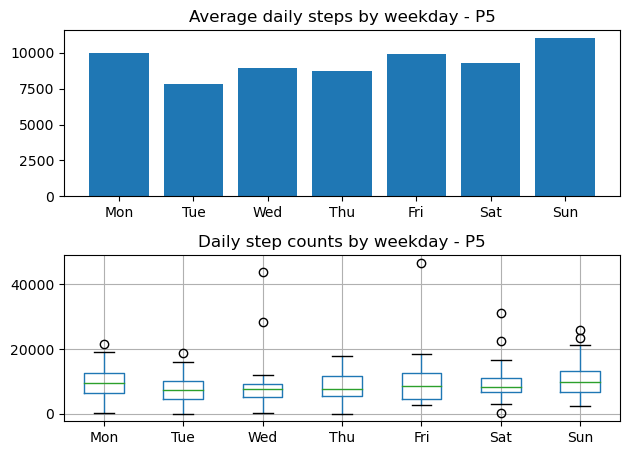

In [9]:
def plot_daily_steps(daily_sums, suffix):
    weekday_avgs = daily_sums.groupby('Weekday')['Count'].agg(np.average)

    fig, axs = plt.subplots(2, 1)
    axs[0].bar(weekdays, weekday_avgs)
    axs[0].set_title('Average daily steps by weekday - ' + suffix)

    daily_sums.boxplot(column='Count', by='Weekday', ax=axs[1])
    axs[1].set_title(f'Daily step counts by weekday - {suffix}')
    axs[1].set_xticks(np.arange(7) + 1, labels=weekdays)
    axs[1].set_xlabel(None)

    fig.suptitle('')
    fig.tight_layout()
    plt.show()

daily_sums_p1 = cleaned_p1.groupby(['Year', 'Month', 'Day', 'Weekday'], as_index=False)['Count'].sum()
plot_daily_steps(daily_sums_p1, 'P1')
daily_sums_p5 = cleaned_p5.groupby(['Year', 'Month', 'Day', 'Weekday'], as_index=False)['Count'].sum()
plot_daily_steps(daily_sums_p5, 'P5')


We can also plot the weekly and month diagrams.

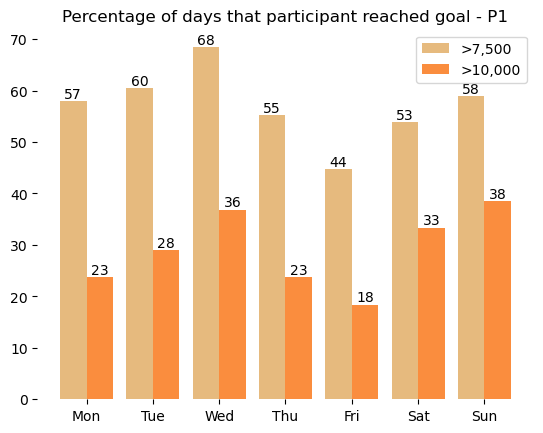

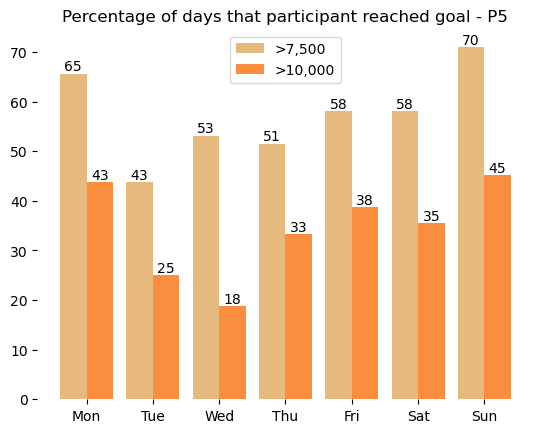

In [10]:
def plot_weekday_patterns(daily_sums, suffix):
    num_weekday_days = daily_sums.groupby('Weekday').size()
    p_days_7500 = daily_sums[daily_sums['Count'] > 7500].groupby('Weekday').size() / num_weekday_days * 100
    p_days_10000 = daily_sums[daily_sums['Count'] > 10000].groupby('Weekday').size() / num_weekday_days * 100

    x = np.arange(7)
    width = 0.4

    fig, ax = plt.subplots()

    bar_7500 = ax.bar(x - width / 2, p_days_7500, width=width, color='#E6BA7E', label='>7,500')
    ax.bar_label(bar_7500, fmt='%d')
    bar_10000 = ax.bar(x + width / 2, p_days_10000, width=width, color='#FA8D3E', label='>10,000')
    ax.bar_label(bar_10000, fmt='%d')

    ax.set(frame_on=False)
    plt.title(f'Percentage of days that participant reached goal - {suffix}')
    plt.xticks(x, labels=weekdays)
    plt.legend()
    plt.show()

plot_weekday_patterns(daily_sums_p1, 'P1')
plot_weekday_patterns(daily_sums_p5, 'P5')

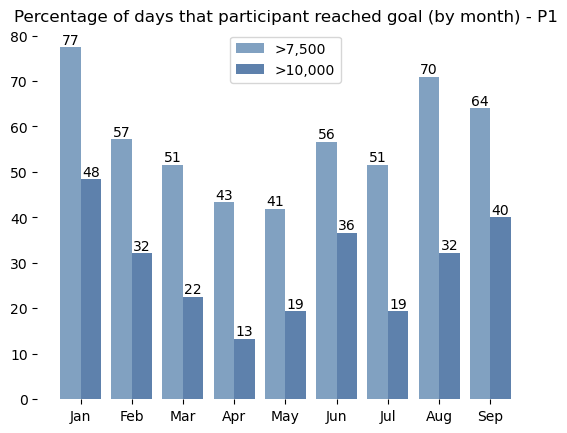

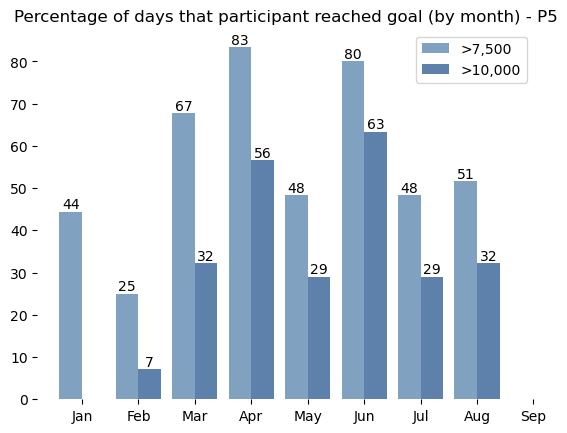

In [11]:
def plot_monthly_patterns(daily_sums, suffix):
    # show only data in 2022
    num_month_days = daily_sums[daily_sums['Year'] == 2022].groupby('Month').size()
    p_days_7500 = daily_sums[daily_sums['Count'] > 7500].groupby('Month').size() / num_month_days * 100
    p_days_10000 = daily_sums[daily_sums['Count'] > 10000].groupby('Month').size() / num_month_days * 100

    x = daily_sums[daily_sums['Year'] == 2022]['Month'].unique()
    labels = [months[mo - 1] for mo in x]
    width = 0.4

    fig, ax = plt.subplots()
    bar_7500 = ax.bar(x - width / 2, p_days_7500, width=width, color='#81A1C1', label='>7,500')
    ax.bar_label(bar_7500, fmt='%d')
    bar_10000 = ax.bar(x + width / 2, p_days_10000, width=width, color='#5E81AC', label='>10,000')
    ax.bar_label(bar_10000, fmt='%d')
    ax.set_xticks(x, labels)

    ax.set(frame_on=False)
    plt.title(f'Percentage of days that participant reached goal (by month) - {suffix}')
    plt.legend()
    plt.show()

plot_monthly_patterns(daily_sums_p1, 'P1')
plot_monthly_patterns(daily_sums_p5, 'P5')



## Uncertainty

One source of uncertainty is the absence of data. From the above plot we can see that participant 5 did not reach the 10,000-step goal at all in January. When inspecting the dataset, we observed that they only wore the tracker for 9 days in January.

It is also possible that the step count data did not cover all forms of physical activity.

## Benefits

By observing the patterns in how often the participant reaches the recommended daily activity levels, we can understand the factors that may influence physical activity. Our results can help public health organisations and the government to make informed decisions when making recommendations. 

## References

[1] A. E. Paluch et al., “Daily steps and all-cause mortality: a meta-analysis of 15 international cohorts,” The Lancet Public Health, vol. 7, no. 3, pp. e219–e228, Mar. 2022, doi: 10.1016/S2468-2667(21)00302-9.

[2] Anthony L. Komaroff, “How many steps should I take each day? - Harvard Health.” https://www.health.harvard.edu/staying-healthy/how-many-steps-should-i-take-each-day (accessed Sep. 20, 2022).